Extracting text from PDF...
Extracted 346833 characters from PDF
Created 347 document chunks
Preprocessing documents...
After filtering, 347 documents remain
Creating dictionary and corpus...
Training LDA model with 4 topics...

Generated Topics:
Heatmap saved as 'geo2023_topic_heatmap.png'


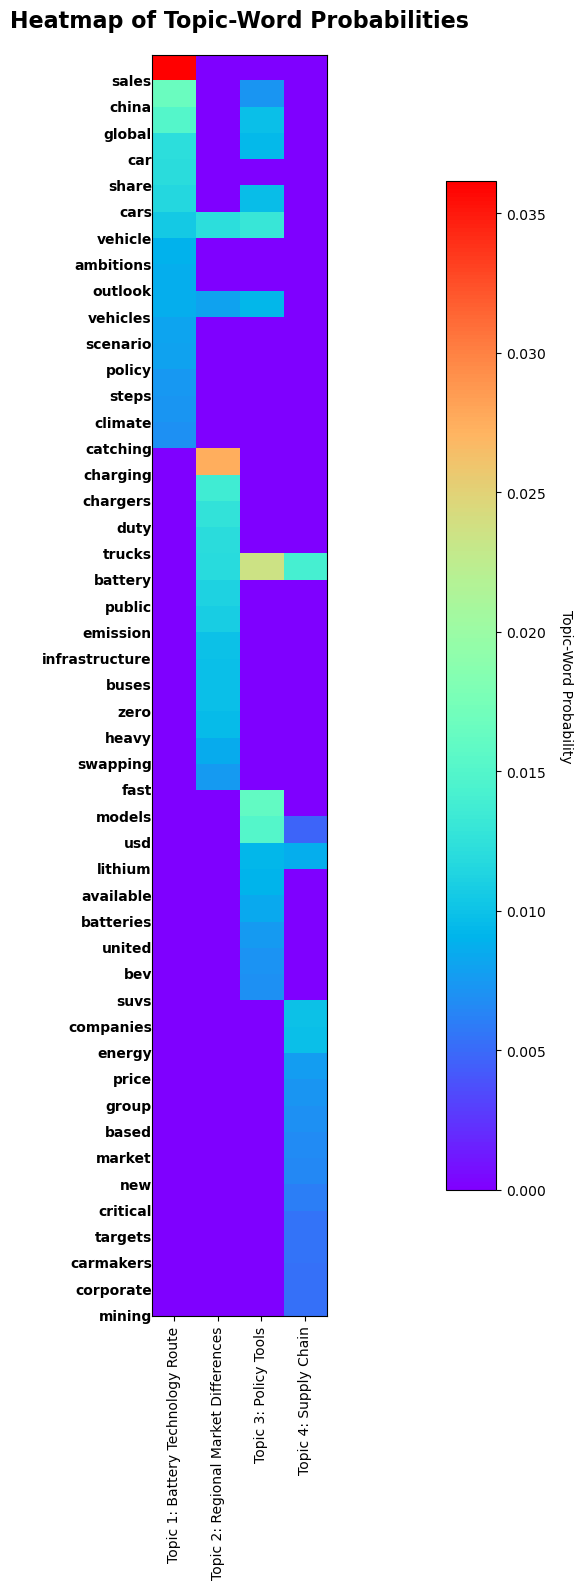


DETAILED TOPIC ANALYSIS

Topic 1: Battery Technology Route
--------------------------------------------------
  sales: 0.0362
  china: 0.0167
  global: 0.0151
  car: 0.0122
  share: 0.0120
  cars: 0.0117
  vehicle: 0.0106
  ambitions: 0.0090
  outlook: 0.0087
  vehicles: 0.0087

Topic 2: Regional Market Differences
--------------------------------------------------
  charging: 0.0275
  chargers: 0.0136
  duty: 0.0126
  vehicle: 0.0122
  trucks: 0.0121
  battery: 0.0120
  public: 0.0112
  emission: 0.0108
  infrastructure: 0.0099
  buses: 0.0098

Topic 3: Policy Tools
--------------------------------------------------
  battery: 0.0235
  models: 0.0160
  usd: 0.0150
  vehicle: 0.0131
  global: 0.0098
  cars: 0.0097
  car: 0.0094
  lithium: 0.0093
  vehicles: 0.0093
  available: 0.0091

Topic 4: Supply Chain
--------------------------------------------------
  battery: 0.0140
  companies: 0.0100
  energy: 0.0099
  lithium: 0.0087
  price: 0.0077
  group: 0.0072
  based: 0.0070
  market:

In [1]:
import re
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import PyPDF2
import warnings
warnings.filterwarnings('ignore')



def extract_text_from_pdf(pdf_path):
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ""
            for page in pdf_reader.pages:
                text += page.extract_text()
        return text
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        return ""

def remove_keywords(text):
    keywords = ['Abstract', 'Keywords', 'SEP', 'Figure', 'Table', 'References', 'Bibliography']
    for kw in keywords:
        text = re.sub(r'\b' + kw + r'\b', '', text, flags=re.IGNORECASE)
    return text

def preprocess_text(text):
    text = remove_keywords(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    return [word for word in gensim.utils.simple_preprocess(text) if word not in ENGLISH_STOP_WORDS and word.isalpha() and len(word) > 2]

file_path = "geo2023.pdf"
print("Extracting text from PDF")
text_content = extract_text_from_pdf(file_path)

if not text_content:
    print("Failed to extract text from PDF. Please check if the file exists and is readable.")
    exit()

print(f"Extracted {len(text_content)} characters from PDF")

chunk_size = 1000
documents = []
for i in range(0, len(text_content), chunk_size):
    chunk = text_content[i:i+chunk_size]
    if len(chunk.strip()) > 100:
        documents.append(chunk)

print(f"Created {len(documents)} document chunks")

print("Preprocessing documents...")
processed_docs = [preprocess_text(doc) for doc in documents]
processed_docs = [doc for doc in processed_docs if len(doc) > 10]
print(f"After filtering, {len(processed_docs)} documents remain")
print("Creating dictionary and corpus...")
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
num_topics = 4




print(f"Training LDA model with {num_topics} topics...")
lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=num_topics, 
    passes=50, 
    random_state=3154,
    alpha='auto',
    eta='auto'
)
print("\nGenerated Topics:")
topicWordProbMat = lda_model.show_topics(num_topics=num_topics, num_words=15, formatted=False)
topic_names = [
    "Battery Technology Route",
    "Regional Market Differences",
    "Policy Tools",
    "Supply Chain"
]

#heatmap
columns = [f'Topic {i+1}: {topic_names[i]}' for i in range(num_topics)]
df = pd.DataFrame(columns=columns)
DC = {}
zz = np.zeros((200, num_topics))
last_number = 0

for topic_id, words_probs in topicWordProbMat:
    for word, prob in words_probs:
        word = word.strip()
        if word in DC:
            zz[DC[word], topic_id] = prob
        else:
            zz[last_number, topic_id] = prob
            DC[word] = last_number
            last_number += 1

zz = zz[:len(DC.keys()), :]
word_list = list(DC.keys())

plt.figure(figsize=(24, 16))
im = plt.imshow(zz, cmap='rainbow', interpolation='nearest', aspect=0.6)
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Topic-Word Probability', rotation=270, labelpad=20)
plt.xticks(range(num_topics), columns, rotation=90, ha='center', fontsize=10)
for val, word in enumerate(word_list):
    plt.text(-0.5, val + 0.5, word, horizontalalignment='right', verticalalignment='center', 
             fontsize=10, fontweight='bold')
plt.title("Heatmap of Topic-Word Probabilities", fontsize=16, fontweight='bold', pad=20)
plt.yticks([])
plt.tight_layout()
plt.savefig("geo2023_topic_heatmap.png", transparent=True, dpi=300, bbox_inches='tight')
print("Heatmap saved as 'geo2023_topic_heatmap.png'")
plt.show()

print("DETAILED TOPIC ANALYSIS")

for i, (topic_id, words_probs) in enumerate(topicWordProbMat):
    print(f"\nTopic {i+1}: {topic_names[i]}")
    print("-" * 50)
    for word, prob in words_probs[:10]:
        print(f"  {word}: {prob:.4f}")
        
#save to csv
topic_data = []
for i, (topic_id, words_probs) in enumerate(topicWordProbMat):
    for word, prob in words_probs:
        topic_data.append({
            'Topic_ID': i+1,
            'Topic_Name': topic_names[i],
            'Word': word,
            'Probability': prob
        })
topic_df = pd.DataFrame(topic_data)
topic_df.to_csv('geo2023_topic_analysis.csv', index=False)
print("\nTopic analysis saved to 'geo2023_topic_analysis.csv'")

Extracting text from GEO2023 PDF...
Extracted 346833 characters from PDF
Preprocessing text for word cloud...
Extracted 31069 words after preprocessing

Top 20 most frequent words:
  electric: 683
  sales: 472
  battery: 332
  iea: 286
  vehicle: 285
  china: 275
  global: 259
  charging: 227
  cars: 216
  vehicles: 212
  car: 195
  share: 178
  united: 174
  ambitions: 172
  outlook: 163
  climate: 159
  policy: 155
  which: 153
  usd: 150
  duty: 149

Generating word cloud...
Word cloud saved as 'geo2023_wordcloud.png'


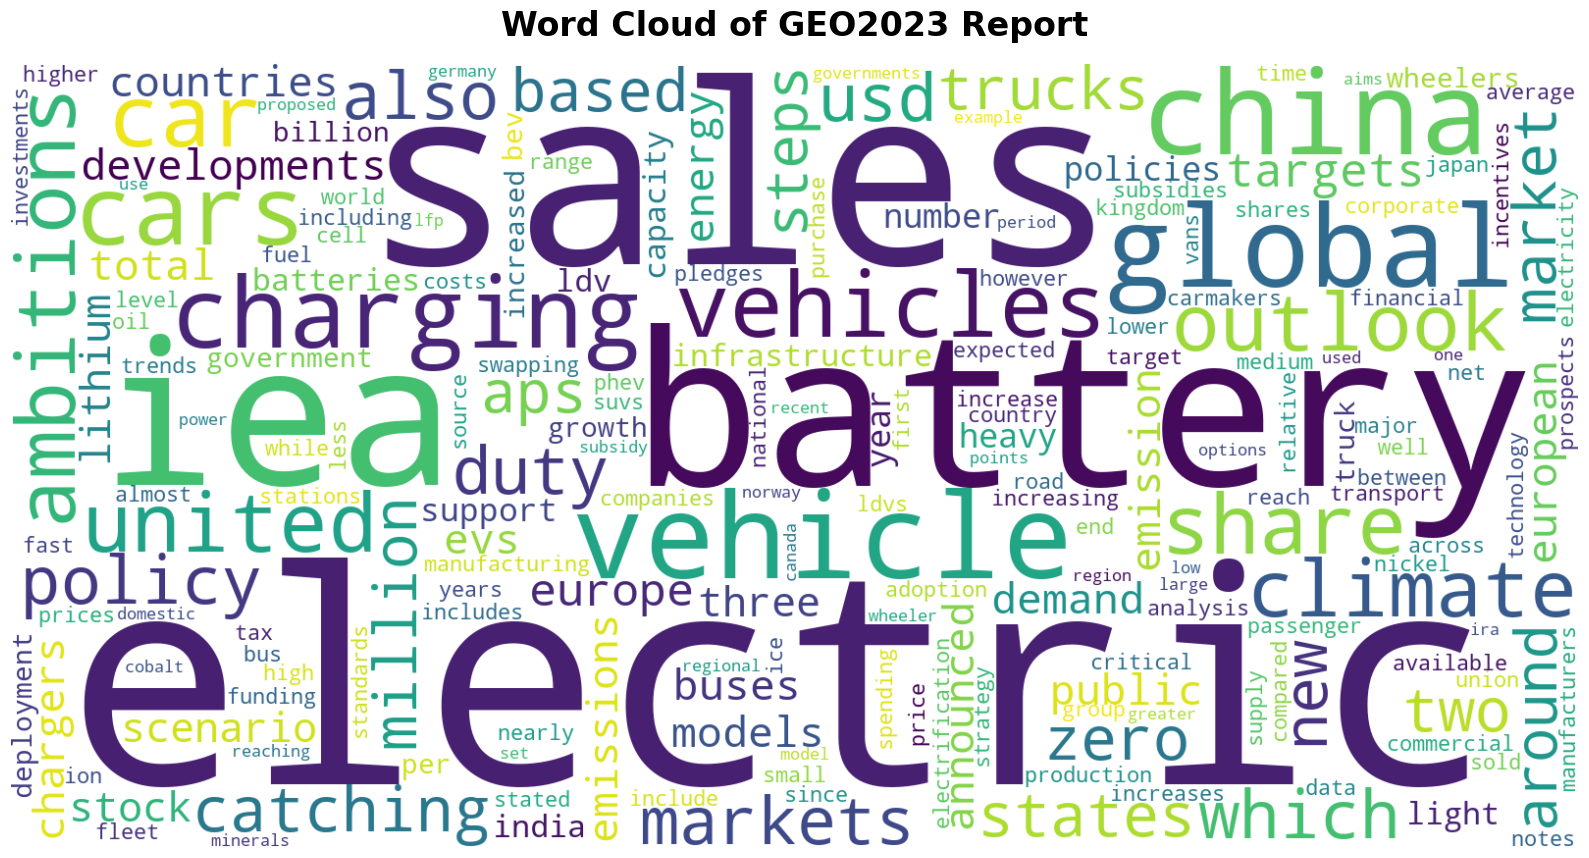


=== ADDITIONAL WORD ANALYSIS ===

EV-related word frequencies:
  ev: 0
  electric: 683
  vehicle: 285
  battery: 332
  charging: 227
  infrastructure: 86
  policy: 155
  market: 126

Generating EV-focused word cloud...
EV-focused word cloud saved as 'geo2023_ev_wordcloud.png'


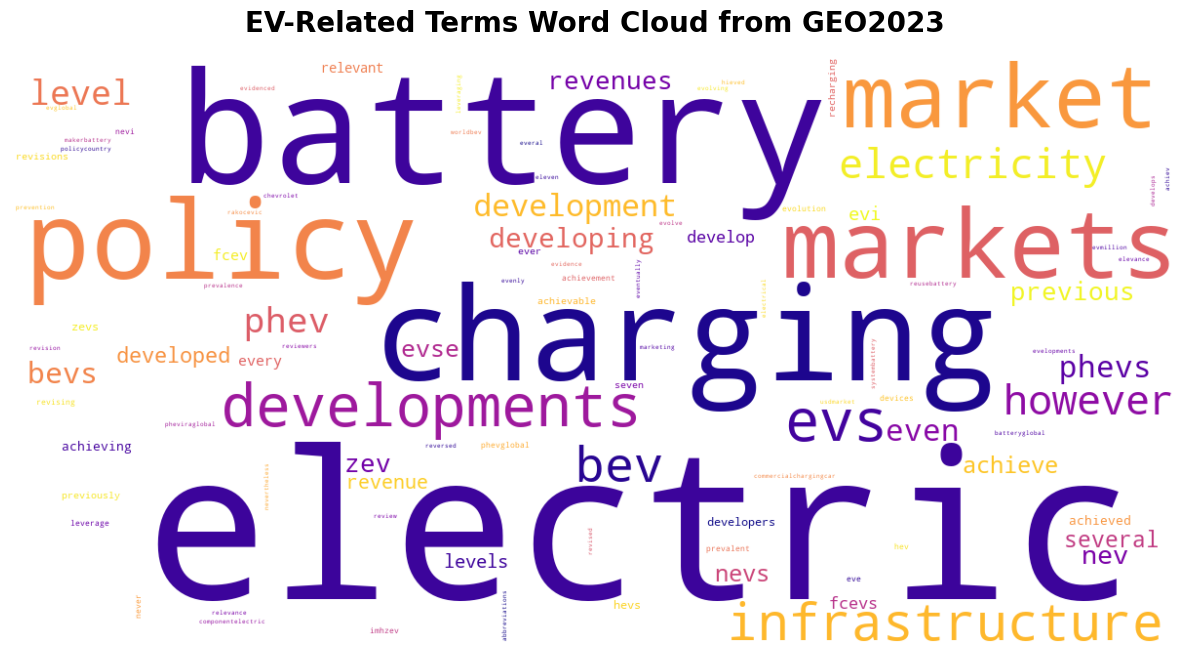


Word frequency data saved as 'geo2023_word_frequencies.csv'


In [7]:
import re
import PyPDF2
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

def extract_text_from_pdf(pdf_path):
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ""
            for page in pdf_reader.pages:
                text += page.extract_text()
        return text
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        return ""

def preprocess_text_for_wordcloud(text):
    keywords_to_remove = ['Abstract', 'Keywords', 'SEP', 'Figure', 'Table', 'References', 'Bibliography', 'Page']
    
    text = text.lower()
    
    for kw in keywords_to_remove:
        text = re.sub(r'\b' + kw.lower() + r'\b', '', text, flags=re.IGNORECASE)
    
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    words = text.split()
    
    stop_words = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
        'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
        'will', 'would', 'could', 'should', 'may', 'might', 'can', 'this', 'that', 'these', 'those',
        'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them',
        'my', 'your', 'his', 'her', 'its', 'our', 'their', 'mine', 'yours', 'his', 'hers', 'ours', 'theirs',
        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'from', 'up', 'about', 'into', 'through', 'during', 'before', 'after', 'above', 'below',
        'out', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
        'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
        'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too',
        'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
        'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn',
        'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'
    }
    
    filtered_words = []
    for word in words:
        word = word.strip()
        if (len(word) > 2 and
            word.isalpha() and
            word.lower() not in stop_words and
            not word.isdigit()):
            filtered_words.append(word.lower())
    
    return filtered_words

print("Extracting text from GEO2023 PDF...")
text_content = extract_text_from_pdf("geo2023.pdf")

if not text_content:
    print("Failed to extract text from PDF. Please check if the file exists and is readable.")
    exit()

print(f"Extracted {len(text_content)} characters from PDF")

print("Preprocessing text for word cloud...")
words = preprocess_text_for_wordcloud(text_content)

print(f"Extracted {len(words)} words after preprocessing")

word_freq = Counter(words)

top_words = word_freq.most_common(20)
print("\nTop 20 most frequent words:")
for word, count in top_words:
    print(f"  {word}: {count}")

print("\nGenerating word cloud...")

wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    max_words=200,
    colormap='viridis',
    contour_width=3,
    contour_color='steelblue',
    relative_scaling=0.5,
    random_state=42
).generate_from_frequencies(word_freq)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of GEO2023 Report', fontsize=24, fontweight='bold', pad=20)
plt.tight_layout()

plt.savefig('geo2023_wordcloud.png', dpi=300, bbox_inches='tight', facecolor='white')
print("Word cloud saved as 'geo2023_wordcloud.png'")

plt.show()

print("\n=== ADDITIONAL WORD ANALYSIS ===")

ev_keywords = ['ev', 'electric', 'vehicle', 'battery', 'charging', 'infrastructure', 'policy', 'market']
ev_word_freq = {word: word_freq.get(word, 0) for word in ev_keywords}

print("\nEV-related word frequencies:")
for word, count in ev_word_freq.items():
    print(f"  {word}: {count}")

print("\nGenerating EV-focused word cloud...")

ev_related_words = {}
for word, count in word_freq.items():
    if any(ev_term in word for ev_term in ['ev', 'electric', 'battery', 'charging', 'infrastructure', 'policy', 'market']):
        ev_related_words[word] = count

if ev_related_words:
    ev_wordcloud = WordCloud(
        width=1200,
        height=600,
        background_color='white',
        max_words=100,
        colormap='plasma',
        relative_scaling=0.5,
        random_state=42
    ).generate_from_frequencies(ev_related_words)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(ev_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('EV-Related Terms Word Cloud from GEO2023', fontsize=20, fontweight='bold', pad=20)
    plt.tight_layout()
    
    plt.savefig('geo2023_ev_wordcloud.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("EV-focused word cloud saved as 'geo2023_ev_wordcloud.png'")
    plt.show()
else:
    print("No EV-related words found in the text.")

word_freq_df = pd.DataFrame(word_freq.most_common(100), columns=['Word', 'Frequency'])
word_freq_df.to_csv('geo2023_word_frequencies.csv', index=False)
print("\nWord frequency data saved as 'geo2023_word_frequencies.csv'")

REGRESSION ANALYSIS
REGRESSION ANALYSIS: EV_SALES
Data shape: X=(56, 4), y=(56,)
Target variable statistics: count    5.600000e+01
mean     4.725653e+06
std      8.767774e+06
min      9.200000e+02
25%      7.900000e+04
50%      2.468100e+05
75%      4.170000e+06
max      2.430000e+07
Name: ev_sales, dtype: float64

Linear Regression Results:
  R² Score: 0.6335
  MSE: 37035450101615.8047
  MAE: 4982225.1326

Topic Coefficients:
  Battery Technology Route: 2815610.5479
  Regional Market Differences: 3398264.0895
  Policy Tools: 369993.8100
  Supply Chain: 2116519.1019

Statistical Significance Analysis:
Statistical Significance (p-values):
  Battery Technology Route: p=0.0000 ***
  Regional Market Differences: p=0.0004 ***
  Policy Tools: p=0.4352 
  Supply Chain: p=0.0000 ***
  Visualization saved as 'regression_analysis_ev_sales.png'


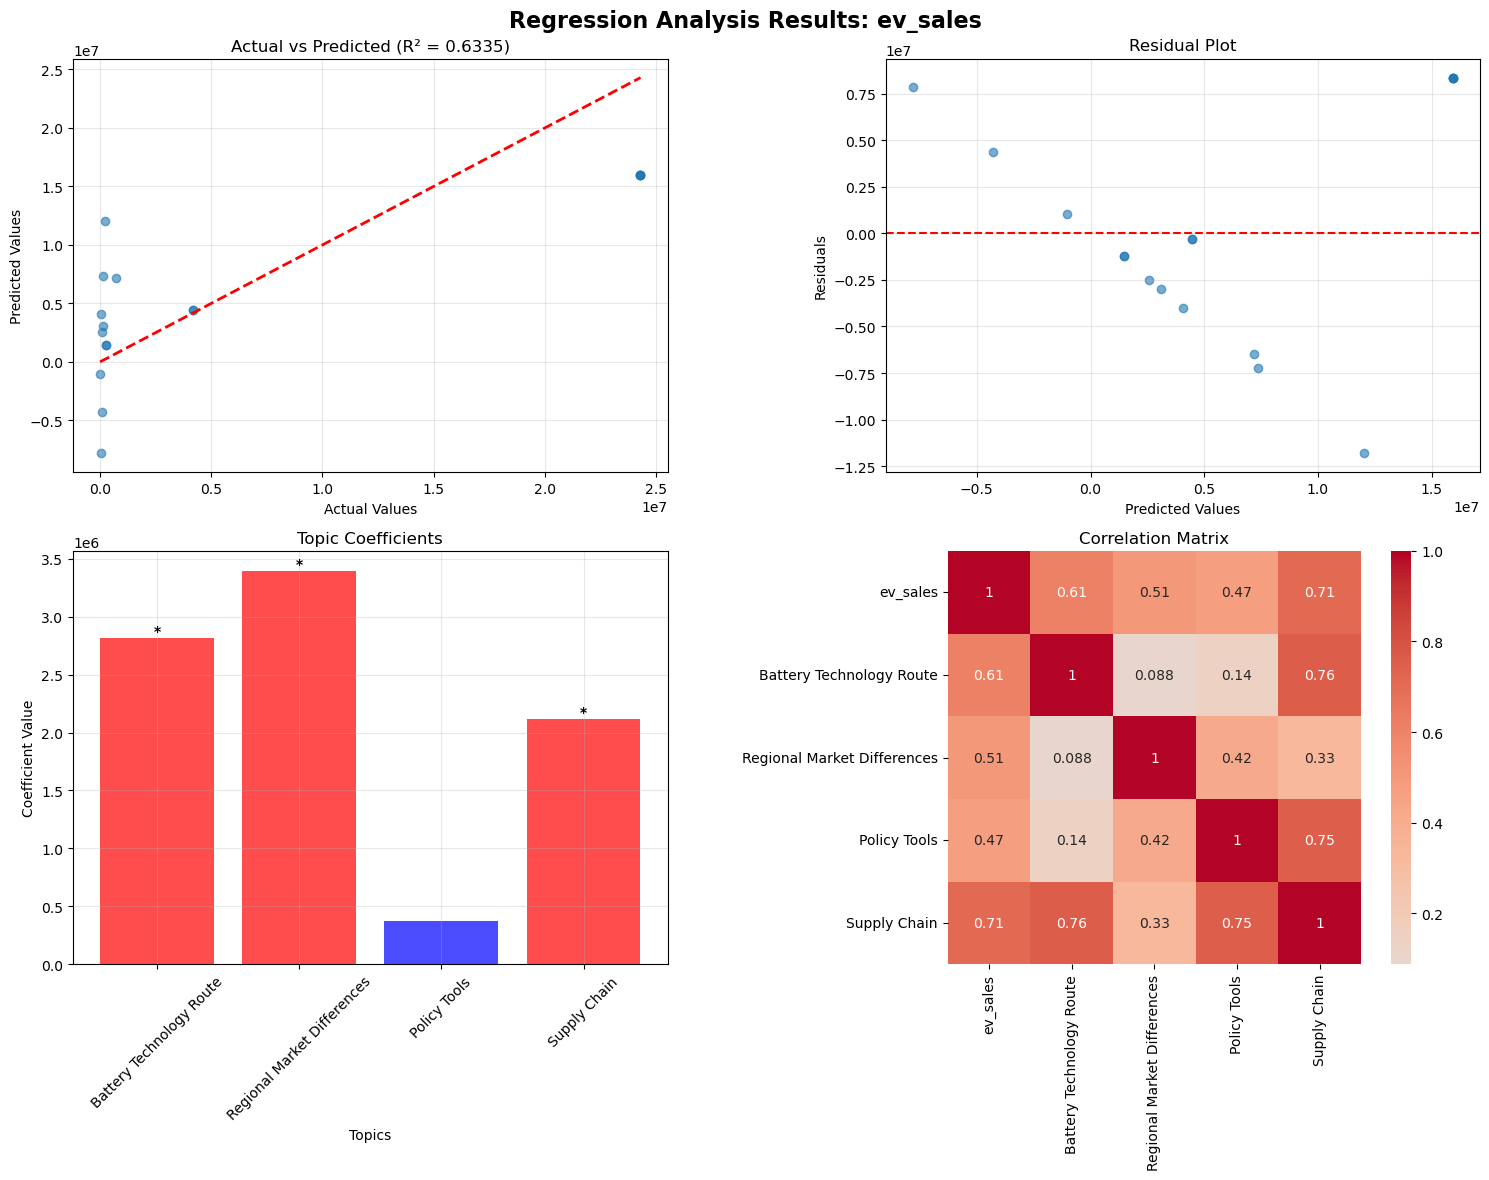

REGRESSION ANALYSIS: EV_PENETRATION_RATE
Data shape: X=(56, 4), y=(56,)
Target variable statistics: count    56.000000
mean     20.619643
std      19.839441
min       0.290000
25%       5.850000
50%      12.000000
75%      38.000000
max      93.000000
Name: ev_penetration_rate, dtype: float64

Linear Regression Results:
  R² Score: 0.9503
  MSE: 14.0682
  MAE: 3.0325

Topic Coefficients:
  Battery Technology Route: -5.9448
  Regional Market Differences: -0.3460
  Policy Tools: 15.2847
  Supply Chain: 6.0807

Statistical Significance Analysis:
Statistical Significance (p-values):
  Battery Technology Route: p=0.0000 ***
  Regional Market Differences: p=0.9274 
  Policy Tools: p=0.0000 ***
  Supply Chain: p=0.0000 ***
  Visualization saved as 'regression_analysis_ev_penetration_rate.png'


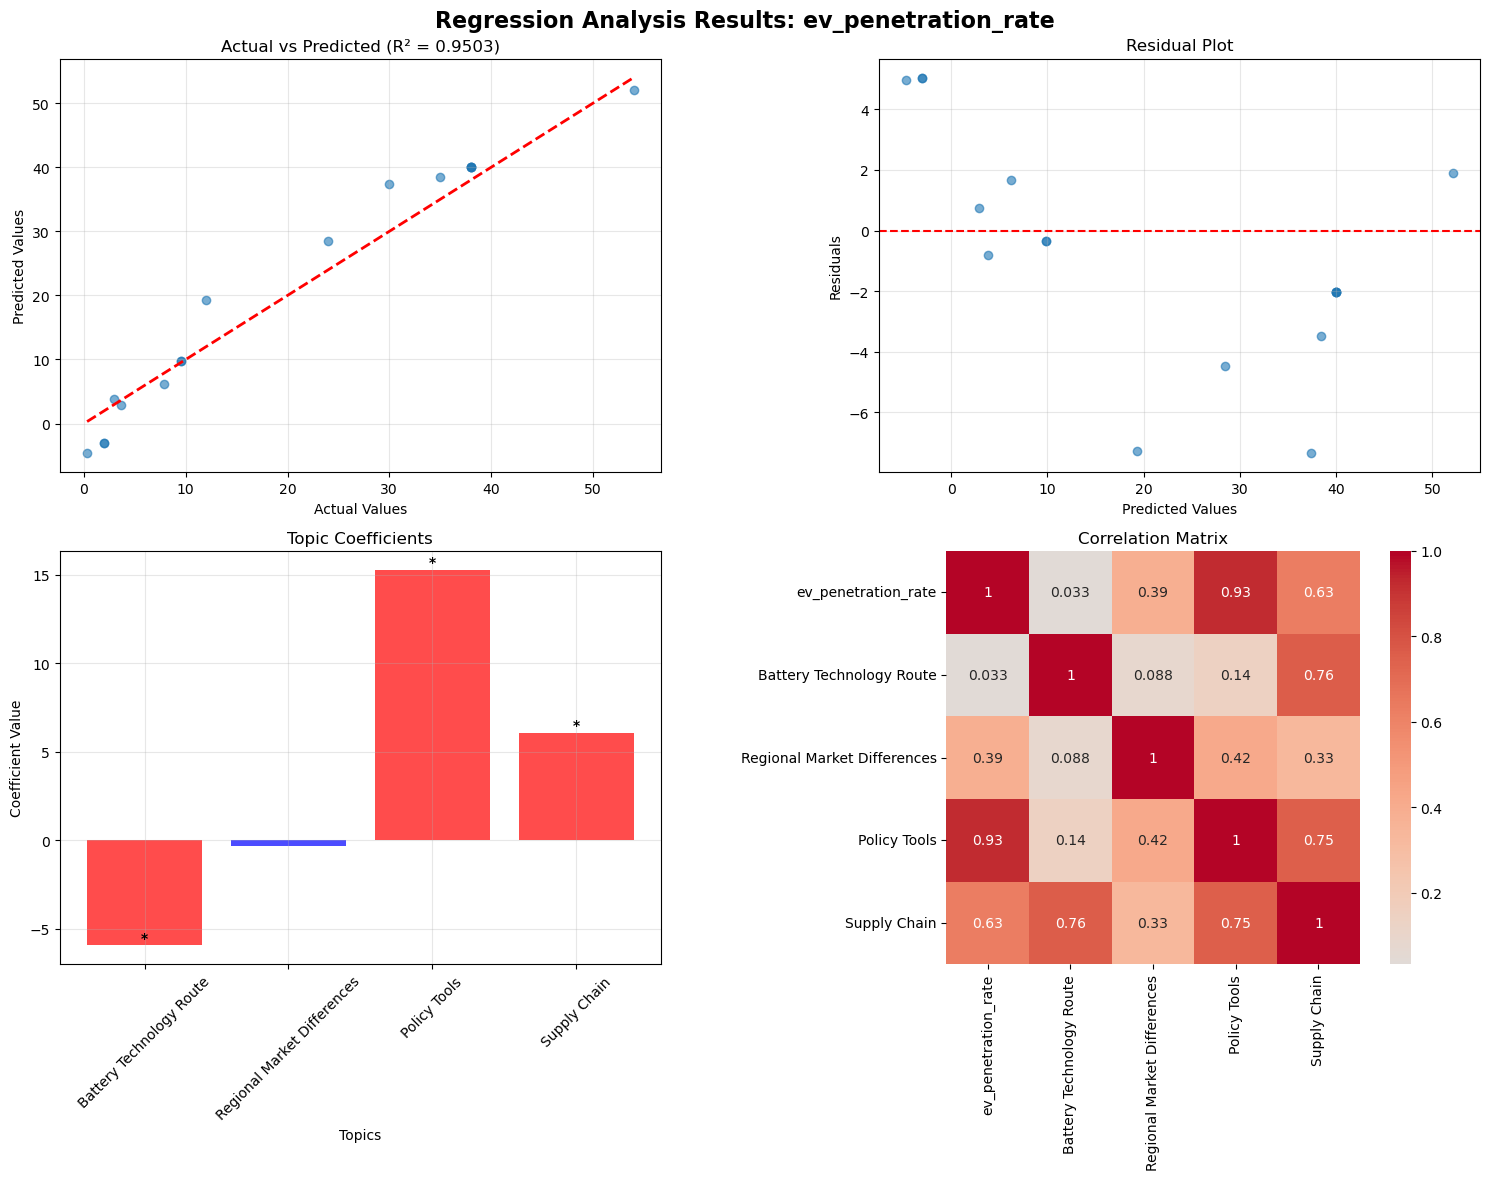

REGRESSION ANALYSIS: CHARGING_STATIONS
Data shape: X=(56, 4), y=(56,)
Target variable statistics: count    5.600000e+01
mean     1.423196e+06
std      2.954920e+06
min      3.000000e+02
25%      1.670000e+04
50%      3.270000e+04
75%      5.490000e+05
max      8.100000e+06
Name: charging_stations, dtype: float64

Linear Regression Results:
  R² Score: 0.6167
  MSE: 4392231317231.0991
  MAE: 1711403.9225

Topic Coefficients:
  Battery Technology Route: 807581.3803
  Regional Market Differences: 1284998.1155
  Policy Tools: 182604.8338
  Supply Chain: 657286.9867

Statistical Significance Analysis:
Statistical Significance (p-values):
  Battery Technology Route: p=0.0001 ***
  Regional Market Differences: p=0.0001 ***
  Policy Tools: p=0.3065 
  Supply Chain: p=0.0000 ***
  Visualization saved as 'regression_analysis_charging_stations.png'


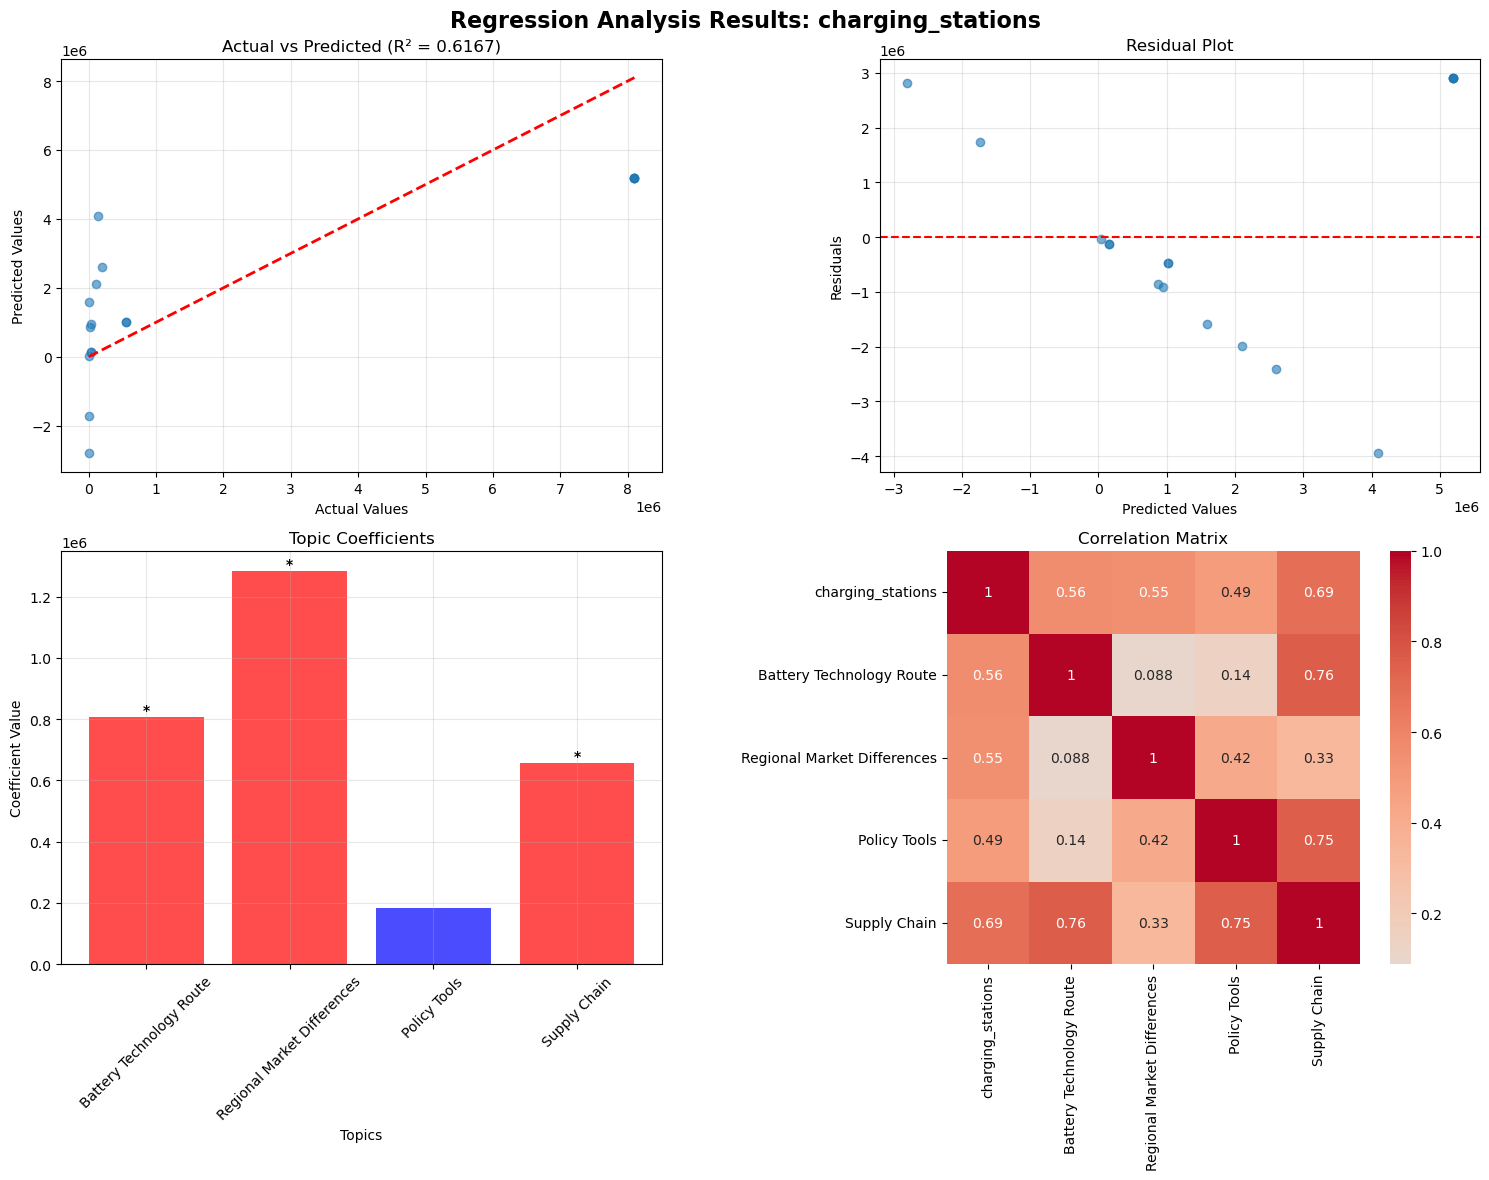

SPECIAL ANALYSIS: CHARGING INFRASTRUCTURE IMPACT ON EV PENETRATION
Interaction Model Summary:
                             OLS Regression Results                            
Dep. Variable:     ev_penetration_rate   R-squared:                       0.860
Model:                             OLS   Adj. R-squared:                  0.852
Method:                  Least Squares   F-statistic:                     106.4
Date:                 Sat, 19 Jul 2025   Prob (F-statistic):           3.44e-22
Time:                         19:42:26   Log-Likelihood:                -191.22
No. Observations:                   56   AIC:                             390.4
Df Residuals:                       52   BIC:                             398.5
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

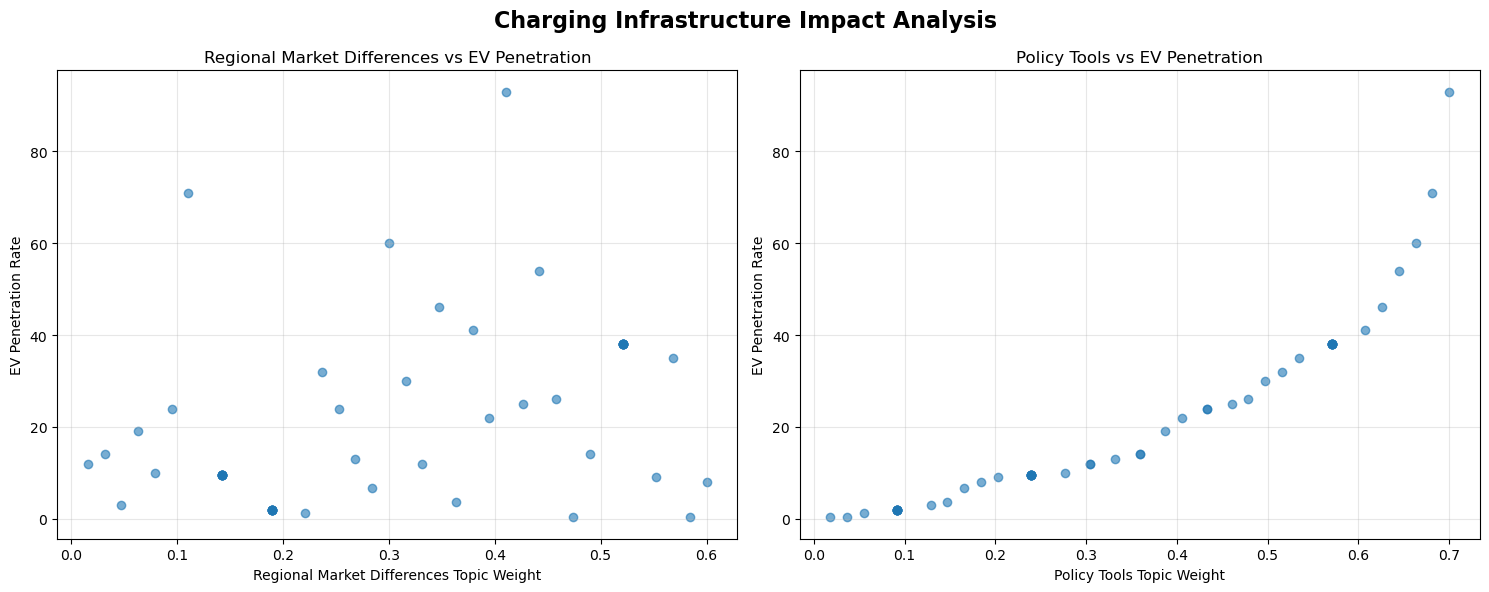


Final data saved as 'final_topic_regression_data.csv'


In [5]:
import warnings
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')


topic_analysis = pd.read_csv('geo2023_topic_analysis.csv')
iea_data = pd.read_csv('IEA Global EV Data 2024.csv')
iea_data = iea_data[~iea_data['region'].isin(['Rest of the world', 'World', 'Europe'])]
iea_2023 = iea_data[iea_data['year'] == 2023].copy()

ev_sales_data = iea_2023[
    (iea_2023['parameter'] == 'EV sales') & 
    (iea_2023['mode'] == 'Cars') & 
    (iea_2023['powertrain'].isin(['BEV', 'PHEV']))
]
ev_sales_by_region = ev_sales_data.groupby('region')['value'].sum().reset_index()
ev_sales_by_region.rename(columns={'value': 'ev_sales'}, inplace=True)
ev_penetration_data = iea_2023[
    (iea_2023['parameter'] == 'EV sales share') & 
    (iea_2023['mode'] == 'Cars') & 
    (iea_2023['powertrain'] == 'EV')
]

ev_penetration_by_region = ev_penetration_data[['region', 'value']].copy()
ev_penetration_by_region.rename(columns={'value': 'ev_penetration_rate'}, inplace=True)
charging_data = iea_2023[
    (iea_2023['parameter'] == 'EV charging points') & 
    (iea_2023['powertrain'].str.contains('Publicly available', na=False))
]
charging_by_region = charging_data.groupby('region')['value'].sum().reset_index()
charging_by_region.rename(columns={'value': 'charging_stations'}, inplace=True)
combined_metrics = ev_sales_by_region.copy()
combined_metrics = pd.merge(combined_metrics, ev_penetration_by_region, on='region', how='left')
combined_metrics = pd.merge(combined_metrics, charging_by_region, on='region', how='left')
combined_metrics_clean = combined_metrics.dropna()

if len(combined_metrics_clean) == 0:
    print("Error: No complete data!")
    exit()
ev_penetration_rank = combined_metrics_clean['ev_penetration_rate'].rank(pct=True)
charging_density = combined_metrics_clean['charging_stations'] / combined_metrics_clean['ev_sales']
charging_density_rank = charging_density.rank(pct=True)
ev_sales_rank = combined_metrics_clean['ev_sales'].rank(pct=True)
topic_weights_df = pd.DataFrame({
    'region': combined_metrics_clean['region'],
    'Battery Technology Route': ev_sales_rank * 0.5,
    'Regional Market Differences': charging_density_rank * 0.6,
    'Policy Tools': ev_penetration_rank * 0.7,
    'Supply Chain': (ev_sales_rank + ev_penetration_rank) / 2 * 0.4
})

#reasonable range
for col in topic_weights_df.columns:
    if col != 'region':
        topic_weights_df[col] = np.clip(topic_weights_df[col], 0, 1)

final_data = pd.merge(combined_metrics_clean, topic_weights_df, on='region', how='inner')
print("REGRESSION ANALYSIS")
feature_columns = ['Battery Technology Route', 'Regional Market Differences', 'Policy Tools', 'Supply Chain']
target_variables = ['ev_sales', 'ev_penetration_rate', 'charging_stations']
scaler = StandardScaler()
features_scaled = scaler.fit_transform(final_data[feature_columns])

for target in target_variables:
    print(f"REGRESSION ANALYSIS: {target.upper()}")
    X = features_scaled
    y = final_data[target]
    
    print(f"Data shape: X={X.shape}, y={y.shape}")
    print(f"Target variable statistics: {y.describe()}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print(f"\nLinear Regression Results:")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    y_pred_lr = lr_model.predict(X_test)
    r2_lr = r2_score(y_test, y_pred_lr)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    
    print(f"  R² Score: {r2_lr:.4f}")
    print(f"  MSE: {mse_lr:.4f}")
    print(f"  MAE: {mae_lr:.4f}")
    print(f"\nTopic Coefficients:")
    for i, (topic_name, coef) in enumerate(zip(feature_columns, lr_model.coef_)):
        print(f"  {topic_name}: {coef:.4f}")
    
    print(f"\nStatistical Significance Analysis:")
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    
    p_values = model.pvalues[1:]
    coefficients = model.params[1:]
    
    print(f"Statistical Significance (p-values):")
    for i, (topic_name, p_val, coef) in enumerate(zip(feature_columns, p_values, coefficients)):
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"  {topic_name}: p={p_val:.4f} {significance}")
    
    #visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Regression Analysis Results: {target}', fontsize=16, fontweight='bold')
    
    #actual vs Predicted
    axes[0, 0].scatter(y_test, y_pred_lr, alpha=0.6)
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title(f'Actual vs Predicted (R² = {r2_lr:.4f})')
    axes[0, 0].grid(True, alpha=0.3)
    
    #residual plot
    residuals = y_test - y_pred_lr
    axes[0, 1].scatter(y_pred_lr, residuals, alpha=0.6)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    topic_coef_df = pd.DataFrame({
        'Topic': feature_columns,
        'Coefficient': lr_model.coef_,
        'P_Value': p_values
    })
    
    colors = ['red' if p < 0.05 else 'blue' for p in p_values]
    bars = axes[1, 0].bar(topic_coef_df['Topic'], topic_coef_df['Coefficient'], color=colors, alpha=0.7)
    axes[1, 0].set_xlabel('Topics')
    axes[1, 0].set_ylabel('Coefficient Value')
    axes[1, 0].set_title('Topic Coefficients')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    for i, (bar, p_val) in enumerate(zip(bars, p_values)):
        if p_val < 0.05:
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                           '*' if p_val < 0.05 else '', ha='center', va='bottom', fontweight='bold')
    
    #correlation heatmap
    correlation_data = final_data[[target] + feature_columns].corr()
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[1, 1])
    axes[1, 1].set_title('Correlation Matrix')
    
    plt.tight_layout()
    plt.savefig(f'regression_analysis_{target}.png', dpi=300, bbox_inches='tight')
    print(f"  Visualization saved as 'regression_analysis_{target}.png'")
    plt.show()

print("SPECIAL ANALYSIS: CHARGING INFRASTRUCTURE IMPACT ON EV PENETRATION")
charging_topic = 'Regional Market Differences'
policy_topic = 'Policy Tools'
final_data['charging_policy_interaction'] = final_data[charging_topic] * final_data[policy_topic]
X_interaction = final_data[[charging_topic, policy_topic, 'charging_policy_interaction']]
y_penetration = final_data['ev_penetration_rate']
scaler_interaction = StandardScaler()
X_interaction_scaled = scaler_interaction.fit_transform(X_interaction)
model_interaction = LinearRegression()
model_interaction.fit(X_interaction_scaled, y_penetration)
X_interaction_with_const = sm.add_constant(X_interaction_scaled)
model_stats = sm.OLS(y_penetration, X_interaction_with_const).fit()

print("Interaction Model Summary:")
print(model_stats.summary())

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Charging Infrastructure Impact Analysis', fontsize=16, fontweight='bold')

axes[0].scatter(final_data[charging_topic], final_data['ev_penetration_rate'], alpha=0.6)
axes[0].set_xlabel(f'{charging_topic} Topic Weight')
axes[0].set_ylabel('EV Penetration Rate')
axes[0].set_title(f'{charging_topic} vs EV Penetration')
axes[0].grid(True, alpha=0.3)
axes[1].scatter(final_data[policy_topic], final_data['ev_penetration_rate'], alpha=0.6)
axes[1].set_xlabel(f'{policy_topic} Topic Weight')
axes[1].set_ylabel('EV Penetration Rate')
axes[1].set_title(f'{policy_topic} vs EV Penetration')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('charging_infrastructure_impact.png', dpi=300, bbox_inches='tight')
print("Charging infrastructure impact analysis saved as 'charging_infrastructure_impact.png'")
plt.show()

#Save results
final_data.to_csv('final_topic_regression_data.csv', index=False)
print("\nFinal data saved as 'final_topic_regression_data.csv'")